In [240]:
import xarray as xr
import datetime as dt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import numpy as np
from shapely.prepared import prep
from shapely.geometry import Point
import itertools
from cmocean import cm

In [241]:
def make_map():
    fig = plt.figure(figsize=(12,9))
    cart_proj = ccrs.PlateCarree()
    ax = plt.axes(projection=cart_proj)
    ax.coastlines('10m', linewidth=0.8,zorder=200)
    ax.set_xlim(-123.3,-122.2)
    ax.set_ylim(37.5,38.1)
    return(fig, ax)

In [242]:
ds_2k = xr.open_dataset('data/sfbay_2km_2020_07_01.nc')
ds_1k = xr.open_dataset('data/sfbay_1km_2020_07_01.nc')
ds_500m = xr.open_dataset('data/sfbay_500m_2020_07_01.nc')
ds_6k = xr.open_dataset('data/sfbay_6km_2020_07_01.nc')

__Calculate Speed__

$ U = \sqrt{u^2 + v^2} $

In [243]:
for ds in [ds_2k, ds_1k, ds_500m,ds_6k]:
    ds['speed'] = np.sqrt(ds.u**2 + ds.v**2)

__Plot Data grids for a single hour__

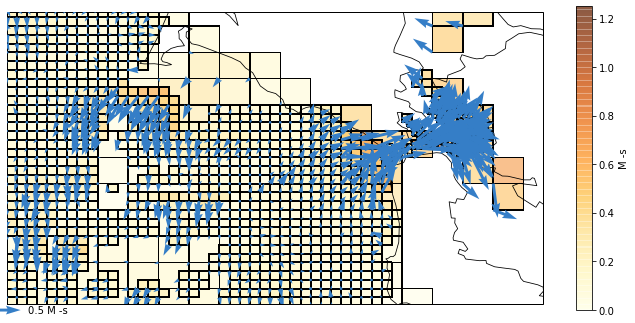

In [244]:
fig = plt.figure(figsize=(12,9))
cart_proj = ccrs.PlateCarree()
ax = plt.axes(projection=cart_proj)
ax.coastlines('10m', linewidth=0.8)
cmaps = ['YlOrBr','Reds', 'Greens', 'Purples',]
for i, ds in enumerate([ds_6k,ds_2k, ds_1k]):
    # Set the GeoAxes to the projection used by WRF

    # Add coastlines
    # # Add arrows to show the wind vectors !!!!
    x = ds.lon
    y = ds.lat
    x,y = np.meshgrid(x,y)

    u = ds.isel(time=0).u
    v = ds.isel(time=0).v
    spd = ds.isel(time=0).speed
    masked = np.ma.masked_array(spd.values, spd.values == np.nan)
    color = ['k','g','r']
    ax.pcolormesh(x, y, masked,vmin=1,vmax=1, zorder=2, facecolor='none', edgecolors='.75', lw=(i+1)/2,
           cmap='gray',transform=ccrs.PlateCarree())
    
    cax = plt.pcolormesh(x,y,masked,transform=ccrs.PlateCarree(),cmap=get_cmap(cmaps[0]),vmin=0,vmax=1.25,alpha=.5)
    
    ax.grid(True, color="k", lw=2,zorder=10,alpha=.75)
    Q = plt.quiver( x, y, u, v,color='#357ec7',width=.006, transform=ccrs.PlateCarree(), zorder=100, scale=10, units="xy")



qk = plt.quiverkey(Q, 
                   0.025, -.02,                  # x,y label position
                   .5,
                   '0.5 M -s', # choose units + update string
                   labelpos='E',                # add label to the right
                   coordinates='axes'
                   )

ax.set_xlim(-123.3,-122.2)
ax.set_ylim(37.5,38.1)
cbar = plt.colorbar(cax, shrink=.62)
cbar.set_label('M -s')

plt.savefig('Figures/all_station.png',dpi=300,bbox_inches='tight', pad_inches=0.25)

# Gap filling logic
1. Create a Land Mask

1. Filling gaps using high or lower resolution data
    - __spatially interpolate__
2. gap is on edge of time (within 3 hours or start times)
    - __spatially interpolate__
3. gap is on the space 
    - __temporal interpolation__
4. gap is less than three hours
    - __temporal interpolation__
5. gap is greater than three hours
    - __spatially interpolate__
    
Spatial filling methods:
- __bilinear interpolation__
- __krigg__

Temporal filling methods:
- __linear interpolation__

__Creating a 1km grid with a land mask__

In [245]:
#2km 
x = ds_2k.lon
y = ds_2k.lat
x,y = np.meshgrid(x,y)


land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m')
land_polygons = list(land_10m.geometries())
land_polygons_prep = [prep(land_polygon) for land_polygon in land_polygons]
points = [Point(point) for point in zip(x.ravel(), y.ravel())]
land = []
# land.extend([tuple(point.coords)[0] for point in filter((land_polygons_prep[0].covers), points)])
land.extend([tuple(point.coords)[0] for point in itertools.filterfalse((land_polygons_prep[0].covers), points)])

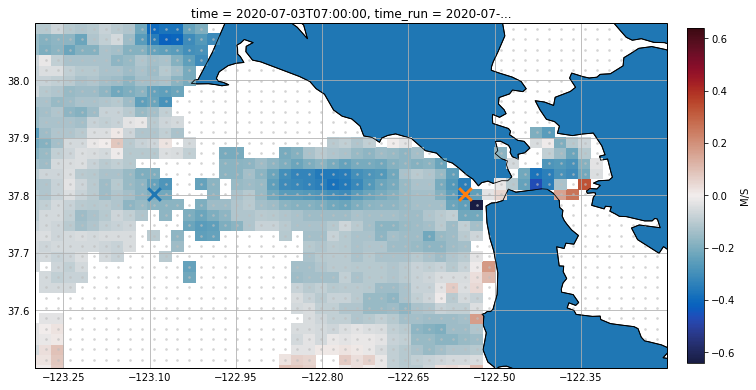

In [247]:
u = ds_2k.isel(time=55).u

fig, ax = make_map()
ax.add_feature(land_10m, zorder=0, edgecolor='black')

xs, ys = zip(*land)
ax.scatter(xs, ys, transform=ccrs.PlateCarree(),
       s=12, marker='.', c='.75', alpha=0.5, zorder=2)

cax = u.plot(cmap=cm.balance,add_colorbar=False)
plt.colorbar(cax,fraction=0.025, pad=0.03,label='M/S')

gl = gridlines = ax.gridlines(draw_labels=True,)
gl.xlabels_top = False
gl.ylabels_right = False
ax.scatter(-123.09319,37.8016, transform=ccrs.PlateCarree(),marker='x',zorder=200,s=160,lw=3)
ax.scatter(-122.55183,37.8016, transform=ccrs.PlateCarree(),marker='x',zorder=200,s=160,lw=3)

# plt.savefig('Figures/2-HFR-pre_interp_u.png',dpi=300,bbox_inches='tight', pad_inches=0.1)
# plt.show()

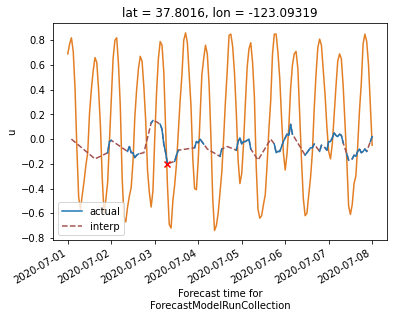

In [272]:
f = ds_2k.sel(lat=37.8,lon=-122.55,method='nearest')
f['u'].plot(color='#E37E24')

p = ds_2k.sel(lat=37.8,lon=-123.1,method='nearest')
p['u'].plot(zorder=10,label='actual')

i = interp.sel(lat=37.8,lon=-123.1,method='nearest')
i.plot(label='interp',ls='dashed',color="#a5514e")


map_point = i.isel(time=55)
x = map_point['time'].values
y= map_point.values
plt.scatter(x,y,zorder=100,marker='x',color='r')

plt.legend()

# plt.savefig('Figures/2-HFR-interp_time_series_together.png',dpi=300,bbox_inches='tight', pad_inches=0.1)

In [296]:
map_point

<xarray.DataArray 'u' ()>
array(-0.19999999, dtype=float32)
Coordinates:
    lat       float32 37.8016
    lon       float32 -123.09319
    time      datetime64[ns] 2020-07-03T07:00:00
    time_run  datetime64[ns] 2020-07-03T07:00:00

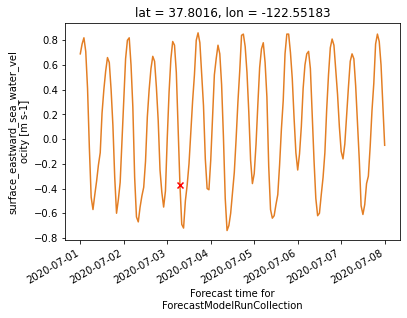

In [271]:
f = ds_2k.sel(lat=37.8,lon=-122.55,method='nearest')
f['u'].plot(color='#E37E24')

map_point = f['u'].isel(time=55)
x = map_point['time'].values
y= map_point.values
plt.scatter(x,y,zorder=100,marker='x',color='r')

plt.savefig('Figures/2-HFR-no-interp_time_series.png',dpi=300,bbox_inches='tight', pad_inches=0.1)

In [170]:
x = map_point['time']
y = map_point[''].values
y

array(0.13, dtype=float32)

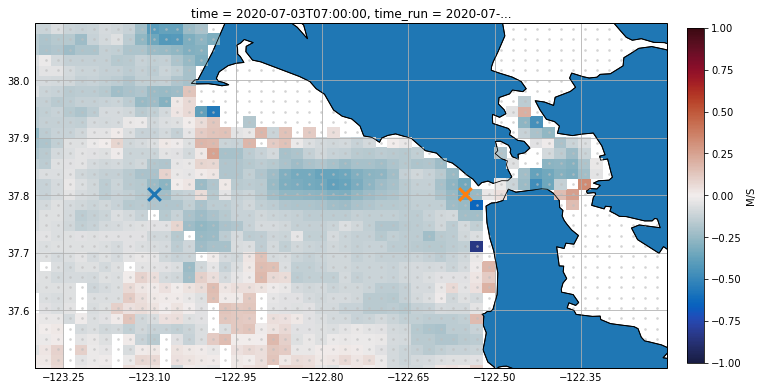

In [196]:
interp_u = ds_2k.isel()['u'].interpolate_na(dim='time',method='linear')
interp_v = ds_2k.isel()['u'].interpolate_na(dim='time',method="linear")

u = interp_u.isel(time=55)

fig, ax = make_map()
ax.add_feature(land_10m, zorder=0, edgecolor='black')

xs, ys = zip(*land)
ax.scatter(xs, ys, transform=ccrs.PlateCarree(),
       s=12, marker='.', c='.75', alpha=0.5, zorder=2)

cax = u.plot(cmap=cm.balance,add_colorbar=False,vmin=-1,vmax=1)
plt.colorbar(cax,fraction=0.025, pad=0.03,label='M/S')

gl = gridlines = ax.gridlines(draw_labels=True,)
gl.xlabels_top = False
gl.ylabels_right = False
ax.scatter(-123.09319,37.8016, transform=ccrs.PlateCarree(),marker='x',zorder=200,s=160,lw=3)
ax.scatter(-122.55183,37.8016, transform=ccrs.PlateCarree(),marker='x',zorder=200,s=160,lw=3)


plt.show()

In [274]:
ds_2k['u_interp'] = interp_u
ds_2k['v_interp'] = interp_v
ds_2k['speed_interp'] = np.sqrt(interp_u**2 + interp_v**2)

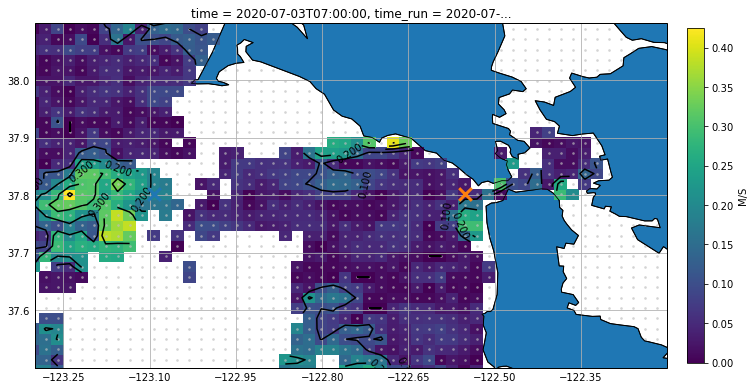

In [275]:
fig, ax = make_map()
ax.add_feature(land_10m, zorder=0, edgecolor='black')

xs, ys = zip(*land)
ax.scatter(xs, ys, transform=ccrs.PlateCarree(),
       s=12, marker='.', c='.75', alpha=0.5, zorder=2)

cax = np.abs((ds_2k['speed'] - ds_2k['speed_interp'])).isel(time=55).plot(add_colorbar=False)
contours = np.abs((ds_2k['speed'] - ds_2k['speed_interp'])).isel(time=55).plot.contour(levels=[0,.1,.2,.3,.4,.5,1],zorder=10,add_labels=True,colors='k')
plt.clabel(contours, inline=1, fontsize=10)

# cax = u.plot(cmap=cm.balance,add_colorbar=False)
plt.colorbar(cax,fraction=0.025, pad=0.03,label='M/S')

gl = gridlines = ax.gridlines(draw_labels=True,)
gl.xlabels_top = False
gl.ylabels_right = False
ax.scatter(-123.09319,37.8016, transform=ccrs.PlateCarree(),marker='x',zorder=200,s=160,lw=3)
ax.scatter(-122.55183,37.8016, transform=ccrs.PlateCarree(),marker='x',zorder=200,s=160,lw=3)


plt.show()


__Calculate Average difference in speed__

In [293]:
ds_2k['dir_interp'] = np.rad2deg(np.arctan2(ds_2k['u_interp'], ds_2k['v_interp']))
ds_2k['dir'] = np.rad2deg(np.arctan2(ds_2k['u'], ds_2k['v']))

# avg_diff_dir = np.abs((ds_2k['dir'] - ds_2k['dir_interp'])).mean(dim={'time'})
# avg_diff_speed = np.abs((ds_2k['speed'] - ds_2k['speed_interp'])).mean(dim={'time'})

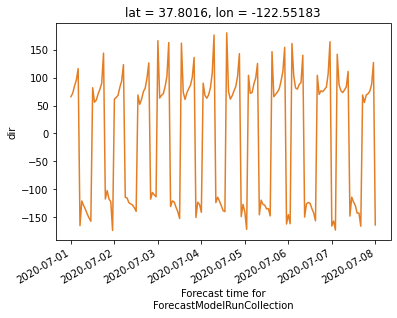

In [294]:
f = ds_2k.sel(lat=37.8,lon=-122.55,method='nearest')
# f['dir_interp'].plot(color='#E37E24')
f['dir'].plot(color='#E37E24')

# p = ds_2k.sel(lat=37.8,lon=-123.1,method='nearest')
# p['dir_interp'].plot(zorder=10,label='actual')
# p['dir'].plot(zorder=10,label='actual')
# i = interp.sel(lat=37.8,lon=-123.1,method='nearest')
# i.plot(label='interp',ls='dashed',color="#a5514e")


# map_point = i.isel(time=55)
# x = map_point['time'].values
# y= map_point.values
# plt.scatter(x,y,zorder=100,marker='x',color='r')

# plt.legend()

# # plt.savefig('Figures/2-HFR-interp_time_series_together.png',dpi=300,bbox_inches='tight', pad_inches=0.1)

In [292]:
np.rad2deg(np.arctan2(1, 0))

90.0

/Users/patrick/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


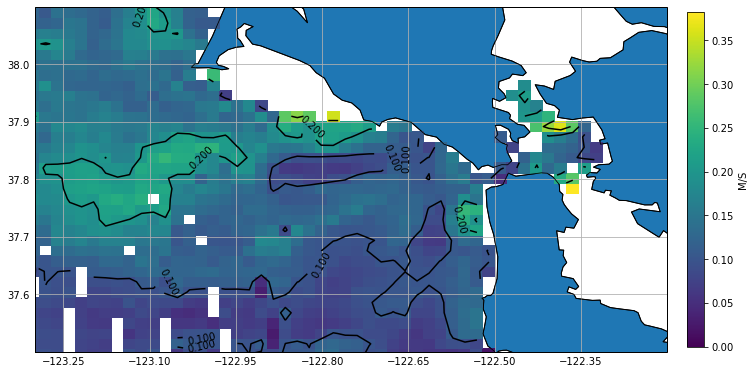

In [232]:
avg_diff_speed = np.abs((ds_2k['speed'] - ds_2k['speed_interp'])).mean(dim={'time'})


fig, ax = make_map()
ax.add_feature(land_10m, zorder=0, edgecolor='black')

cax = avg_diff_speed.plot(add_colorbar=False)
contours = avg_diff_speed.plot.contour(levels=[0,.1,.2,.3,.4,.5,1],zorder=10,add_labels=True,colors='k')
plt.clabel(contours, inline=1, fontsize=10)
plt.colorbar(cax,fraction=0.025, pad=0.03,label='M/S')

gl = gridlines = ax.gridlines(draw_labels=True,)
gl.xlabels_top = False
gl.ylabels_right = False



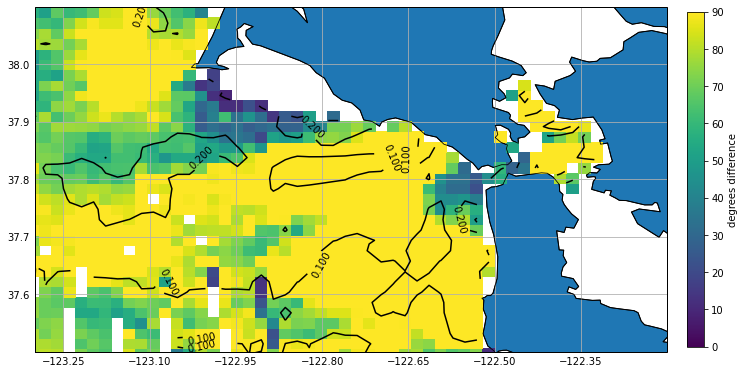

In [239]:
fig, ax = make_map()
ax.add_feature(land_10m, zorder=0, edgecolor='black')

cax = avg_diff_dir.plot(add_colorbar=False,vmin=0,vmax=90)
contours = avg_diff_speed.plot.contour(levels=[0,.1,.2,.3,.4,.5,1],zorder=10,add_labels=True,colors='k')
plt.clabel(contours, inline=1, fontsize=10)
plt.colorbar(cax,fraction=0.025, pad=0.03,label='degrees difference')

gl = gridlines = ax.gridlines(draw_labels=True,)
gl.xlabels_top = False
gl.ylabels_right = False




## 1. Filling gaps using high or lower resolution data
Example 1. Using 6km data to fill 2km data


In [14]:
from scipy import interpolate

In [24]:
u2 = ds_2k.isel(time=3).u.values
coord_2k = np.meshgrid(ds_2k.lon.values, ds_2k.lat.values)

u6 = ds_6k.isel(time=3).u.values
coord_6k = ds_6k.lon.values, ds_6k.lat.values

In [29]:
coord_2k[0].shape

(56, 88)

In [21]:
interpolate.griddata(coord_2k,u2,coord_6k)

ValueError: shape mismatch: objects cannot be broadcast to a single shape

In [ ]:
fig,ax = make_map()
ax.pcolor(x2,y2,u2, transform=ccrs.PlateCarree(),cmap=get_cmap('Reds'))


In [34]:
x = np.arange(-5.01, 5.01, 0.25)
y = np.arange(-5.01, 5.01, 0.25)
xx, yy = np.meshgrid(x, y)
z = np.sin(xx**2+yy**2)
f = interpolate.interp2d(x, y, z, kind='cubic')

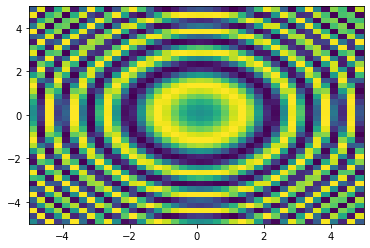

In [36]:
fig, ax = plt.subplots()
ax.pcolormesh(xx,yy,z)

In [38]:
xnew = np.arange(-5.01, 5.01, 1e-2)
ynew = np.arange(-5.01, 5.01, 1e-2)
znew = f(xnew, ynew)

In [ ]:
fig, ax = plt.subplots()
ax.pcolormesh(xnew,ynew,z)

In [39]:
import xarray as xr

In [42]:
ds = xr.open_dataset("http://thredds.cencoos.org/thredds/dodsC/cencoos/staticsensors/m1/OS_M1_20180806_D_M.nc")

/Users/patrick/anaconda3/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'wind_speed' has multiple fill values {-999.0, -3276.8}, decoding all values to NaN.
  use_cftime=use_cftime,


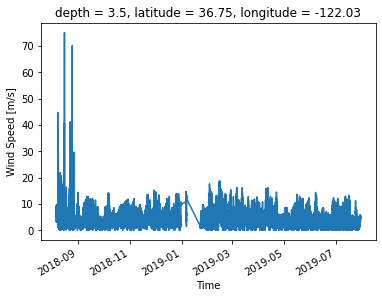

In [45]:
ds['wind_speed'].plot()